# 1-Project description

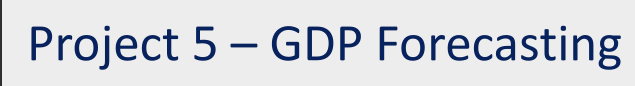

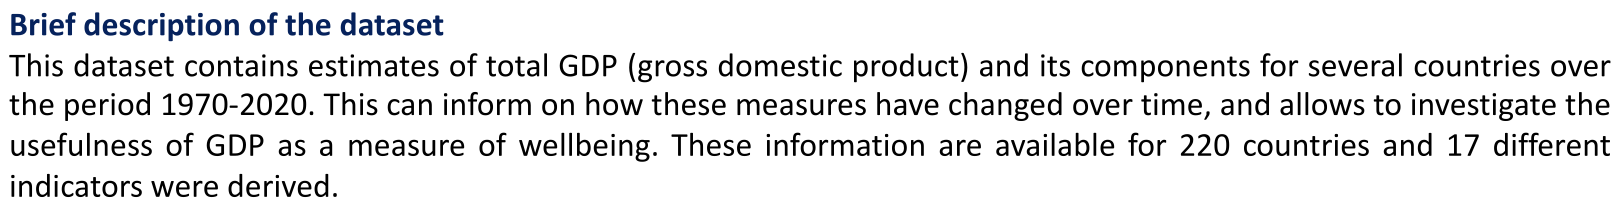

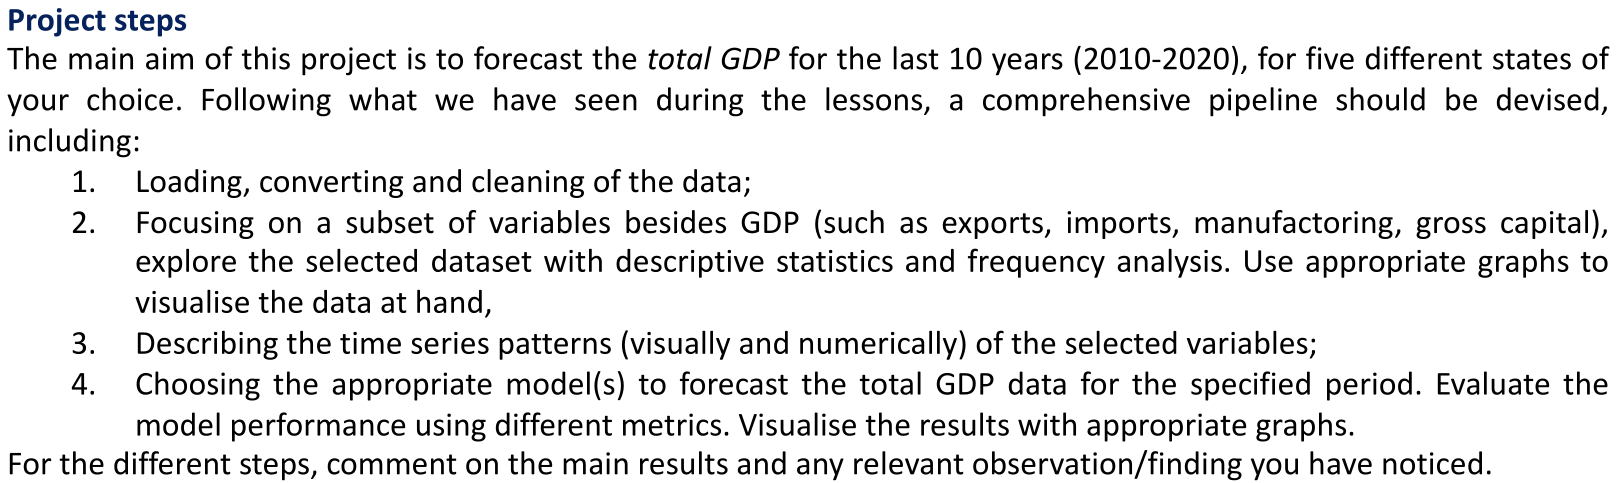

# 2-Modules

In [1]:
import pandas as pd
import functions as f

# 3-Create dataframes

In [2]:
df = pd.read_excel('GDPconstant-USD-countries.ods', index_col = 'CountryID', engine = 'odf')

In [3]:
df.head(5)

,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
CountryID,,,,,,,,,,,,,,,,,,,,,
4,Afghanistan,Final consumption expenditure,3.068715e+09,2.957075e+09,2.886788e+09,3.100416e+09,3.328662e+09,3.514642e+09,3.587322e+09,3.825474e+09,...,1.153494e+10,1.537617e+10,1.849492e+10,1.856572e+10,1.912682e+10,1.930930e+10,1.813094e+10,2.154508e+10,2.494428e+10,2.210259e+10
4,Afghanistan,Household consumption expenditure (including N...,2.734161e+09,2.614420e+09,2.529175e+09,2.724908e+09,2.941860e+09,3.012107e+09,3.032225e+09,3.230522e+09,...,8.263218e+09,1.170813e+10,1.463690e+10,1.460849e+10,1.497766e+10,1.494902e+10,1.404900e+10,1.767663e+10,1.998886e+10,1.835413e+10
4,Afghanistan,General government final consumption expenditure,3.288787e+08,3.375334e+08,3.530078e+08,3.704164e+08,3.810549e+08,4.980797e+08,5.512724e+08,5.909253e+08,...,3.284910e+09,3.673733e+09,3.855382e+09,3.956030e+09,4.149161e+09,4.363228e+09,4.084496e+09,3.854648e+09,4.947607e+09,3.730520e+09
4,Afghanistan,Gross capital formation,1.654637e+09,1.764946e+09,1.615795e+09,1.566079e+09,1.914097e+09,2.257143e+09,3.214193e+09,3.311137e+09,...,3.424102e+09,3.502218e+09,3.362394e+09,2.670612e+09,2.564176e+09,2.570764e+09,2.781503e+09,3.190771e+09,2.640315e+09,3.441861e+09
4,Afghanistan,Gross fixed capital formation (including Acqui...,1.653901e+09,1.764161e+09,1.543641e+09,1.543641e+09,1.984681e+09,2.293410e+09,3.418062e+09,3.219594e+09,...,3.318640e+09,3.518975e+09,3.286279e+09,2.474054e+09,2.564176e+09,2.547500e+09,2.756332e+09,3.161896e+09,2.616422e+09,3.410714e+09


ITALY, JAPAN, UAE, CANADA, SOUTH AFRICA

In [4]:
df_italy = df[df['Country'] == 'Italy']
df_italy = f.create_df(df_italy)
df_japan = df[df['Country'] == 'Japan']
df_japan = f.create_df(df_japan)
df_uae = df[df['Country'] == 'United Arab Emirates']
df_uae = f.create_df(df_uae)
df_canada = df[df['Country'] == 'Canada']
df_canada = f.create_df(df_canada)
df_safrica = df[df['Country'] == 'South Africa']
df_safrica = f.create_df(df_safrica)

In [5]:
df_canada

,Final consumption expenditure,Household consumption expenditure (including Non-profit institutions serving households),General government final consumption expenditure,Gross capital formation,Gross fixed capital formation (including Acquisitions less disposals of valuables),Changes in inventories,Exports of goods and services,Imports of goods and services,Gross Domestic Product (GDP),"Agriculture, hunting, forestry, fishing (ISIC A-B)","Mining, Manufacturing, Utilities (ISIC C-E)",Manufacturing (ISIC D),Construction (ISIC F),"Wholesale, retail trade, restaurants and hotels (ISIC G-H)","Transport, storage and communication (ISIC I)",Other Activities (ISIC J-P),Total Value Added
1970,365057194418.518982,231381188593.950989,134539792355.460999,76109532881.593002,81728758343.864502,952567054.879709,80921145184.651901,63756354059.685204,458105081416.669006,14589585953.809601,114110785188.496002,65965722722.567902,38883332431.2005,41352402501.325897,23147775349.6567,206845083123.809998,444915102458.161987
1971,382381024356.812988,244120432511.178009,139124098835.299011,82585245286.712097,87662731572.913193,840743426.310544,84859367337.797806,67973369321.529999,476293001859.676025,16042976438.641701,118492922069.854004,70181368259.099304,38892698899.431503,43181832871.698402,24089857149.303699,216561056459.812012,463489689893.439026
1972,404034990900.703003,261085149993.623993,143788568051.395996,87532103153.575394,91281645604.443695,582446106.643943,92188505846.371597,77706199286.851807,502535239804.973999,14216863452.548599,129340832534.212997,76023388749.122406,38805278527.621902,47595333638.624298,25619526050.562599,224913490551.329987,487743620805.01001
1973,428541511890.934021,278906547770.232971,150477981386.546997,98424054297.709,98771642228.545807,-76688214.75422,101488738423.539001,88906303009.1996,536887253580.84198,15387303014.388201,147085828317.009003,83787798043.480896,39835590050.3955,51135697183.674004,27578959072.2584,234647960715.02301,524891374935.594971
1974,451393961741.775024,293086646353.645996,159211544496.315002,109281020135.524002,104085736218.914993,-1140659419.43742,96909613249.296997,97869824238.412292,554498889656.105957,14319134870.887699,145082476039.247986,85853090085.757996,41110990828.934402,53949485826.400597,29361144744.531601,245155327483.319,537399048117.375
1975,472971586540.770996,304637144376.969971,169339605205.596008,109071111645.487,108507541454.830002,-264411980.290073,88869770400.497894,95022092570.558304,562601431791.682007,14915718142.2202,131929686733.768997,79605042934.455902,45781736398.676201,55723825395.618301,30113838965.310299,255457786751.713013,540017110840.362
1976,491352708601.909973,320437592545.346008,171866401454.774994,116349126680.184998,115458622659.182007,-336772864.857386,95773755419.829697,100845630768.479004,595674689041.639038,16320245616.427799,136160580451.690002,86101469523.9543,51443766538.162003,60160194042.344597,30845894797.003201,264445035468.940002,565510383179.300049
1977,506876350942.843994,329526562523.435974,178355407949.277008,116761948272.932999,118268741874.531006,116003582.946381,101917857896.822006,100477737875.679993,616154887053.405029,16140702460.6616,140248439856.56601,88941387851.923599,53929002816.795998,60135247264.599701,32271157725.514301,274313729429.587006,583232059225.504028
1978,518522981873.687012,339367779388.403015,180130678546.02301,117257567029.020004,120485126417.729004,440715396.555982,112075536223.748001,103635771726.479004,638851006964.563965,16065703420.237801,143155003213.665985,93878354497.541794,51220532374.935799,62294182990.517197,34375059476.480904,285016739595.692017,598346109905.75
1979,528064879106.56897,347385491055.789978,181631224765.380005,133407741918.378006,128072110949.923004,-1202114015.59478,116302482015.110992,111062394609.141006,662559844174.68396,14819128469.858299,151972349284.657013,97660753708.4245,51880868396.383598,64432329735.382599,38091183688.289803,294678846137.171021,622773653392.624023
